In [0]:
!pip install tf-nightly

     |████████████████████████████████| 519.3MB 30kB/s 
     |████████████████████████████████| 460kB 53.8MB/s 
     |████████████████████████████████| 3.0MB 54.1MB/s 


In [0]:
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

Tensor Flow Verion: 2.2.0-dev20200422


'/device:GPU:0'

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
100% 10.8G/10.8G [04:17<00:00, 55.5MB/s]
100% 10.8G/10.8G [04:17<00:00, 45.2MB/s]


In [0]:
!unzip \*.zip

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

**Load the model**

In [0]:
cd /content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images

/content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images


In [0]:
model = tf.keras.models.load_model('CustomedVGG/saved_model/CustomedVGG_model')

**Add noise to test data**

Noise free

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
cd /content

/content


In [0]:
train_data_dir = 'OCT2017 /train'
validation_data_dir = 'OCT2017 /test'

In [0]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16
nb_train_samples = 83484
nb_validation_samples = 968

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
61/61 [==============================] - 4s 68ms/step - loss: 0.0322 - accuracy: 0.9897

Test result: 98.967 loss: 0.032


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Confusion Matrix
[[233   8   1   0]
 [  1 241   0   0]
 [  0   0 242   0]
 [  0   0   0 242]]


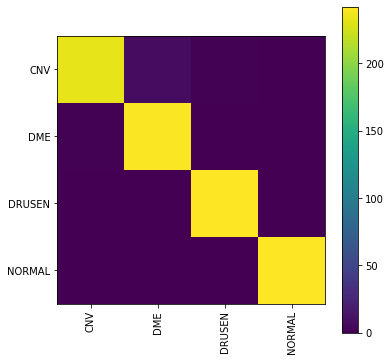

In [0]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [0]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       1.00      0.96      0.98       242
         DME       0.97      1.00      0.98       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



Amplitude = 1

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 154ms/step - loss: 0.0346 - accuracy: 0.9886

Test result: 98.864 loss: 0.035


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[234   7   1   0]
 [  1 241   0   0]
 [  0   0 242   0]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       1.00      0.97      0.98       242
         DME       0.97      1.00      0.98       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



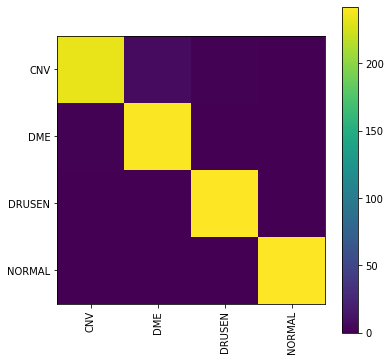

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 2

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=2):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.0434 - accuracy: 0.9876

Test result: 98.760 loss: 0.043


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[234   8   0   0]
 [  1 241   0   0]
 [  0   0 242   0]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       1.00      0.97      0.98       242
         DME       0.97      1.00      0.98       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



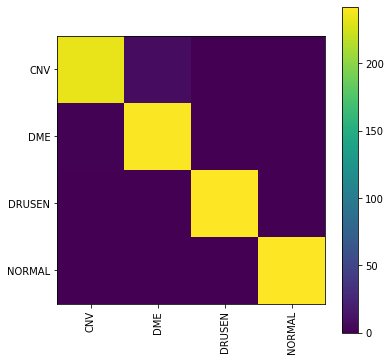

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 3

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=3):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 156ms/step - loss: 0.0690 - accuracy: 0.9876

Test result: 98.760 loss: 0.069


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[228  14   0   0]
 [  1 241   0   0]
 [  0   0 241   1]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       1.00      0.94      0.97       242
         DME       0.95      1.00      0.97       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



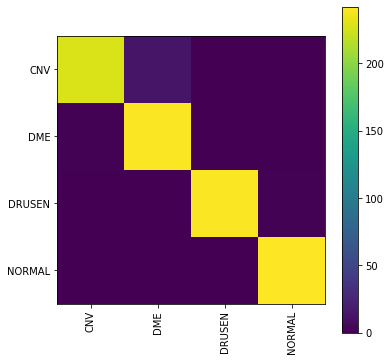

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 4

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=4):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 157ms/step - loss: 0.1308 - accuracy: 0.9669

Test result: 96.694 loss: 0.131


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[216  26   0   0]
 [  1 241   0   0]
 [  1   1 239   1]
 [  0   3   1 238]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.99      0.89      0.94       242
         DME       0.89      1.00      0.94       242
      DRUSEN       1.00      0.99      0.99       242
      NORMAL       1.00      0.98      0.99       242

    accuracy                           0.96       968
   macro avg       0.97      0.96      0.97       968
weighted avg       0.97      0.96      0.97       968



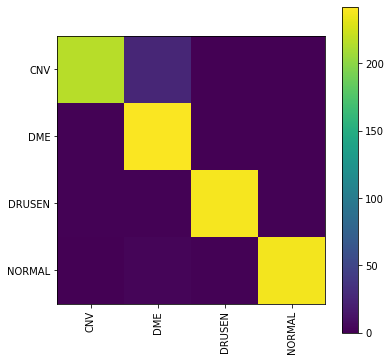

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 5

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=5):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.1724 - accuracy: 0.9504

Test result: 95.041 loss: 0.172


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[201  41   0   0]
 [  2 239   0   1]
 [  3   0 238   1]
 [  0   7   2 233]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.98      0.83      0.90       242
         DME       0.83      0.99      0.90       242
      DRUSEN       0.99      0.98      0.99       242
      NORMAL       0.99      0.96      0.98       242

    accuracy                           0.94       968
   macro avg       0.95      0.94      0.94       968
weighted avg       0.95      0.94      0.94       968



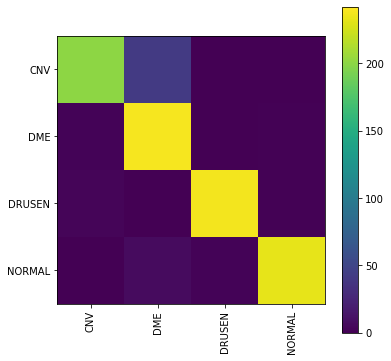

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 6

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=6):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 157ms/step - loss: 0.2439 - accuracy: 0.9287

Test result: 92.872 loss: 0.244


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[197  43   2   0]
 [  1 238   1   2]
 [  4   1 237   0]
 [  0   8   3 231]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.98      0.81      0.89       242
         DME       0.82      0.98      0.89       242
      DRUSEN       0.98      0.98      0.98       242
      NORMAL       0.99      0.95      0.97       242

    accuracy                           0.93       968
   macro avg       0.94      0.93      0.93       968
weighted avg       0.94      0.93      0.93       968



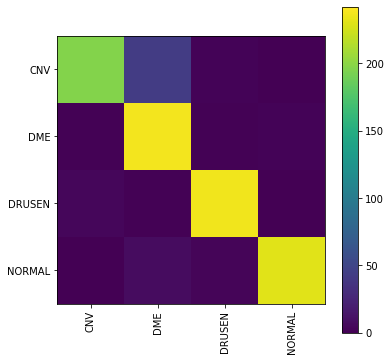

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 7

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=7):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 159ms/step - loss: 0.2845 - accuracy: 0.8967

Test result: 89.669 loss: 0.284


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[195  47   0   0]
 [  2 237   0   3]
 [ 18   2 221   1]
 [  0  14   5 223]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.91      0.81      0.85       242
         DME       0.79      0.98      0.87       242
      DRUSEN       0.98      0.91      0.94       242
      NORMAL       0.98      0.92      0.95       242

    accuracy                           0.90       968
   macro avg       0.91      0.90      0.91       968
weighted avg       0.91      0.90      0.91       968



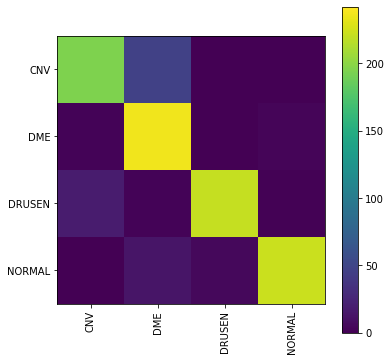

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 8

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=8):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [0]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [0]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 158ms/step - loss: 0.3599 - accuracy: 0.8667

Test result: 86.674 loss: 0.360


In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[203  39   0   0]
 [  1 237   1   3]
 [ 20   5 215   2]
 [  0  29  15 198]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.91      0.84      0.87       242
         DME       0.76      0.98      0.86       242
      DRUSEN       0.93      0.89      0.91       242
      NORMAL       0.98      0.82      0.89       242

    accuracy                           0.88       968
   macro avg       0.89      0.88      0.88       968
weighted avg       0.89      0.88      0.88       968



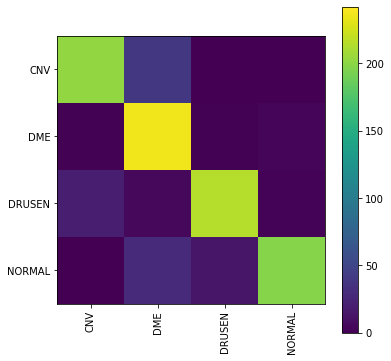

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))